<a href="https://colab.research.google.com/github/open-mmlab/mmsegmentation/blob/main/demo/MMSegmentation_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMSegmentation Tutorial
Welcome to MMSegmentation! 

In this tutorial, we demo
* How to do inference with MMSeg trained weight
* How to train on your own dataset and visualize the results. 

## Install MMSegmentation
This step may take several minutes. 

We use PyTorch 1.12 and CUDA 11.3 for this tutorial. You may install other versions by change the version number in pip install command. 

In [6]:
# Check Pytorch installation
# import torch
# print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
# import mmseg
# print(mmseg.__version__)


import os
import mmengine
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch
torch.cuda.empty_cache()

import os.path as osp
# define dataset root and directory for images and annotations

# define class and palette for better visualization
classes = ('bg', 'signal')
palette=[[120, 120, 120], [6, 230, 230]]

from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset


# @DATASETS.register_module()
# class ECGDataset(BaseSegDataset):
#   METAINFO = dict(classes = classes, palette = palette)
#   def __init__(self, **kwargs):
#     super().__init__(img_suffix='.png', seg_map_suffix='.png', **kwargs)



# data_folder = '/scratch/hshang/moody/final_phase_submission/train_data'
data_folder = '/scratch/hshang/moody/final_phase_submission/official-phase-mins-eth/TeamCode/src/processed_data'
model_folder = '/scratch/hshang/moody/final_phase_submission/mmsegunet_model'
config_dir = '/scratch/hshang/moody/final_phase_submission/official-phase-mins-eth/TeamCode/src/configs_ckpts/'
    
    


data_root = data_folder#os.path.join(data_folder, 'mrcnn_data')
split_dir = 'splits'
img_dir = 'cropped_img'
ann_dir = 'cropped_masks'

import os.path as osp
import numpy as np
from PIL import Image

# convert dataset annotation to semantic segmentation map
# for file in mmengine.scandir(osp.join(data_root, ann_dir), suffix='.png'):
#     seg_map = np.array(Image.open(osp.join(data_root, ann_dir, file))).astype(np.uint8)
#     seg_map = np.where(seg_map < 50, 0, 1).astype(np.uint8)
#     seg_img = Image.fromarray(seg_map).convert('P')
#     # print(np.unique(seg_map))

#     seg_img.putpalette(np.array(palette, dtype=np.uint8))
#     seg_img.save(osp.join(data_root, ann_dir, file), format='PNG')
  
  
mmengine.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmengine.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
# select first 4/5 as train set
    train_length = int(len(filename_list)*4/5)
    f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
# select last 1/5 as train set
    f.writelines(line + '\n' for line in filename_list[train_length:])
from mmengine import Config
from mmengine.runner import Runner

cfg = Config.fromfile('/scratch/hshang/moody/final_phase_submission/official-phase-mins-eth/TeamCode/src/configs_ckpts/unet/unet.py')

crop_size = (256, 256)

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(
        keep_ratio=True,
        ratio_range=(0.5, 1.5),  # Adjusted to prevent aggressive downscaling
        scale=(256, 256),  # Increased scale size
        type='RandomResize'),
    dict(cat_max_ratio=0.75, crop_size=crop_size, type='RandomCrop'),
    dict(type='ResizeToMultiple', size_divisor=16),
    dict(prob=0.5, type='RandomFlip'),
    dict(type='PackSegInputs'),
]

# cfg.val_pipeline = [
#     dict(type='LoadImageFromFile'),
#     dict(keep_ratio=True, scale=(512, 512), type='Resize'),  # Match with training scale
#     dict(type='ResizeToMultiple', size_divisor=16),
#     dict(type='LoadAnnotations'),
#     dict(type='PackSegInputs'),
# ]

# # Since we use only one GPU, BN is used instead of SyncBN
# cfg.norm_cfg = dict(type='BN', requires_grad=True)
# cfg.crop_size = (256, 256)
# cfg.model.data_preprocessor.size = cfg.crop_size
# cfg.model.backbone.norm_cfg = cfg.norm_cfg
# cfg.model.decode_head.norm_cfg = cfg.norm_cfg
# cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg

cfg.data_root = data_root
cfg.load_from = os.path.join(config_dir, "original_pretrained_weights", 'deeplabv3_unet_s5-d16_ce-1.0-dice-3.0_64x64_40k_drive_20211210_201825-6bf0efd7.pth')
cfg.work_dir = model_folder
cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2


cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path='cropped_img', seg_map_path='cropped_masks')
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path='cropped_img', seg_map_path='cropped_masks')
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'

cfg.test_dataloader = cfg.val_dataloader

cfg.train_dataloader.batch_size = 8  # Try reducing the batch size

cfg.train_cfg.max_iters = 200
cfg.train_cfg.val_interval = 200
cfg.default_hooks.logger.interval = 10
cfg.default_hooks.checkpoint.interval = 200

cfg.dataset_type = 'HRFDataset'
# Set seed to facilitate reproducing the result
cfg['randomness'] = dict(seed=0)
runner = Runner.from_cfg(cfg)

runner.train()

# import os

# # Set CUDA_LAUNCH_BLOCKING
# os.environ['CUDA_LAUNCH_BLOCKING'] = '0'

# Now any CUDA code executed will run synchronously.


08/21 11:58:28 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.19 (default, Mar 20 2024, 19:58:24) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 0
    GPU 0: NVIDIA TITAN X (Pascal)
    CUDA_HOME: /usr
    NVCC: Cuda compilation tools, release 11.2, V11.2.152
    GCC: gcc (Debian 10.2.1-6) 10.2.1 20210110
    PyTorch: 1.12.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,

/scratch_net/narigpu01/hshang/conda_envs/openmmlab/lib/python3.8/site-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmseg.visualization.local_visualizer.SegLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


08/21 11:58:54 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
08/21 11:58:54 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/scratch/hshang/moody/mmsegmentation_MINS/mmseg/models/losses/cross_entropy_loss.py:238: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
/scratch/hshang/moody/mmsegmentation_MINS/mmseg/engine/hooks/visualization_hook.py:60: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


08/21 11:58:57 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.
Loads checkpoint by local backend from path: /scratch/hshang/moody/final_phase_submission/official-phase-mins-eth/TeamCode/src/configs_ckpts/original_pretrained_weights/deeplabv3_unet_s5-d16_ce-1.0-dice-3.0_64x64_40k_drive_20211210_201825-6bf0efd7.pth
08/21 11:59:00 - mmengine - INFO - Load checkpoint from /scratch/hshang/moody/final_phase_submission/official-phase-mins-eth/TeamCode/src/configs_ckpts/original_pretrained_weights/deeplabv3_unet_s5-d16_ce-1.0-dice-3.0_64x64_40k_drive_20211210_201825-6bf0efd7.pth
08/21 11:59:00 - mmengine - WARNING - "FileClient" will be deprecated in future. Please use io functions in https://mmengine.readthedocs.io/en/latest/api/fileio.html#file-io
08/21 11:59:00 - mmengine - INFO - Checkpoints will be saved to /scratch/hshang/moody/final_phase_submission/mmsegunet_model.


/opt/conda/conda-bld/pytorch_1659484810403/work/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [256,0,0], thread: [101,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1659484810403/work/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [386,0,0], thread: [11,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1659484810403/work/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [385,0,0], thread: [11,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1659484810403/work/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [10,0,0], thread: [76,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1659484810403/work/aten/src/ATen/native/cuda/Sc

RuntimeError: CUDA error: device-side assert triggered

In [14]:
from mmseg.apis import init_model, inference_model, show_result_pyplot
import matplotlib.pyplot as plt
import mmcv

from mmengine import Config
cfg = Config.fromfile('/scratch/hshang/moody/final_phase_submission/mmsegunet_model/unet.py')

# Init the model from the config and the checkpoint
checkpoint_path = '/scratch/hshang/moody/final_phase_submission/mmsegunet_model/iter_200.pth'

from mmseg.apis import MMSegInferencer
# Load models into memory
# inferencer = MMSegInferencer(model=cfg, weights=checkpoint_path)
# # Inference
# result = inferencer('/scratch/hshang/moody/final_phase_submission/processed_data/cropped_img/1.png')


model = init_model(cfg, checkpoint_path, 'cpu')

img = mmcv.imread('/scratch/hshang/moody/final_phase_submission/official-phase-mins-eth/TeamCode/src/processed_data/cropped_img/12.png')
print(img.shape)
result = inference_model(model, img)
type(result.pred_sem_seg)
pred_res = result.pred_sem_seg.data.cpu().detach().numpy().squeeze(0).astype(bool)
print(pred_res.shape)
# result.gt_sem_seg
# plt.figure(figsize=(8, 6))
# vis_result = show_result_pyplot(model, img, result, draw_gt=False, draw_pred=True, with_labels=False, )
# print(vis_result.shape)
# plt.imshow(vis_result)
# # plt.imshow(result['predictions'])
# plt.


/scratch/hshang/moody/mmsegmentation_MINS/mmseg/models/losses/cross_entropy_loss.py:238: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /scratch/hshang/moody/final_phase_submission/mmsegunet_model/iter_200.pth
(126, 438, 3)
(126, 438)


True


## Finetune a semantic segmentation model on a new dataset

To finetune on a customized dataset, the following steps are necessary. 
1. Add a new dataset class. 
2. Create a config file accordingly. 
3. Perform training and evaluation. 

### Add a new dataset

Datasets in MMSegmentation require image and semantic segmentation maps to be placed in folders with the same prefix. To support a new dataset, we may need to modify the original file structure. 

In this tutorial, we give an example of converting the dataset. You may refer to [docs](https://github.com/open-mmlab/mmsegmentation/blob/master/docs/en/tutorials/customize_datasets.md#customize-datasets-by-reorganizing-data) for details about dataset reorganization. 

We use [Stanford Background Dataset](http://dags.stanford.edu/projects/scenedataset.html) as an example. The dataset contains 715 images chosen from existing public datasets [LabelMe](http://labelme.csail.mit.edu), [MSRC](http://research.microsoft.com/en-us/projects/objectclassrecognition), [PASCAL VOC](http://pascallin.ecs.soton.ac.uk/challenges/VOC) and [Geometric Context](http://www.cs.illinois.edu/homes/dhoiem/). Images from these datasets are mainly outdoor scenes, each containing approximately 320-by-240 pixels. 
In this tutorial, we use the region annotations as labels. There are 8 classes in total, i.e. sky, tree, road, grass, water, building, mountain, and foreground object. 

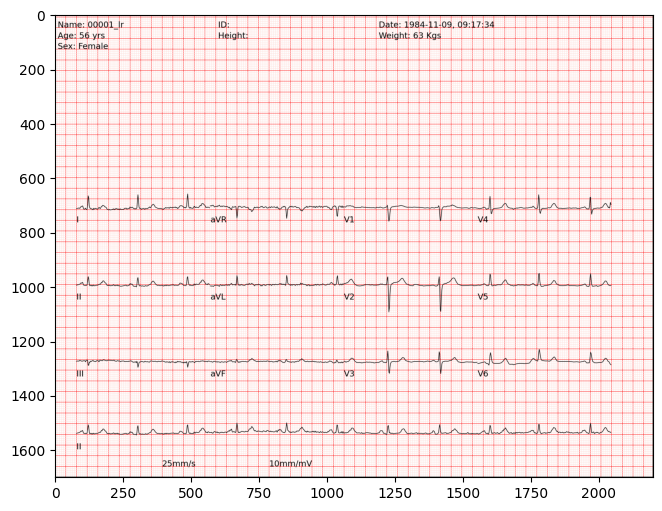

In [3]:
# Let's take a look at the dataset
import mmcv
import mmengine
import matplotlib.pyplot as plt


img = mmcv.imread('/scratch/hshang/moody/mmsegmentation_MINS/demo/ECGData/images/00001_lr-0.png')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

We need to convert the annotation into semantic map format as an image.

In [2]:
# define dataset root and directory for images and annotations
data_root = '/scratch/hshang/moody/training_data'
img_dir = 'cropped_img'
ann_dir = 'cropped_masks'
# define class and palette for better visualization
classes = ('bg', 'signal')
palette = [[255,255,255], [0,0,0]]

In [5]:
# resize the image and label to the closest multiple of 16
import os.path as osp
import numpy as np
from PIL import Image
import mmengine
import mmcv
for file in mmengine.scandir(osp.join(data_root, ann_dir), suffix='.png'):
    # print(f'processing {file}')
    img = mmcv.imread(osp.join(data_root, img_dir, file), flag='color')
    h, w = img.shape[:2]
    if h % 16 == 0 and w % 16 == 0:
        continue
    seg_map = mmcv.imread(osp.join(data_root, ann_dir, file), flag='grayscale')
    h = h // 16 * 16
    w = w // 16 * 16
    print(f'reshaping {file} from {img.shape} to {(h, w)}')
    seg_map = Image.fromarray(seg_map)
    img = Image.fromarray(img)
    seg_map = seg_map.resize((w, h), Image.NEAREST)
    img = img.resize((w, h), Image.NEAREST)
    seg_map.save(osp.join(data_root, ann_dir, file))
    img.save(osp.join(data_root, img_dir, file))


processing 12244.png
processing 3834.png
processing 4100.png
processing 5137.png
processing 2141.png
processing 9452.png
processing 10125.png
processing 5965.png
processing 8368.png
processing 2108.png
processing 5861.png
processing 9226.png
processing 8179.png
processing 8855.png
processing 9715.png
processing 12566.png
processing 36.png
processing 4773.png
processing 5837.png
processing 4642.png
processing 9938.png
processing 3141.png
processing 12207.png
processing 3417.png
processing 2514.png
processing 6928.png
processing 4285.png
processing 4279.png
processing 11176.png
processing 10967.png
processing 9836.png
processing 11379.png
processing 1168.png
processing 1729.png
processing 801.png
processing 4868.png
processing 176.png
processing 9529.png
processing 6437.png
processing 5080.png
processing 3026.png
processing 1599.png
processing 6920.png
processing 10809.png
processing 3033.png
processing 4376.png
processing 988.png
processing 5884.png
processing 11537.png
processing 11194

In [11]:
import os.path as osp
import numpy as np
from PIL import Image
import mmengine
import mmcv
for file in mmengine.scandir(osp.join(data_root, ann_dir), suffix='.png'):
  seg_map = mmcv.imread(osp.join(data_root, ann_dir, file), flag='grayscale')
  seg_img = Image.fromarray(seg_map).convert('P')
  seg_img.putpalette(np.array(palette, dtype=np.uint8))
  seg_img.save(osp.join(data_root, ann_dir, file))
# convert dataset annotation to semantic segmentation map
# for file in mmengine.scandir(osp.join(data_root, ann_dir), suffix='.regions.txt'):
#   seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
#   seg_img = Image.fromarray(seg_map).convert('P')
#   seg_img.putpalette(np.array(palette, dtype=np.uint8))
#   seg_img.save(osp.join(data_root, ann_dir, file.replace('.regions.txt', 
#                                                          '.png')))

: 

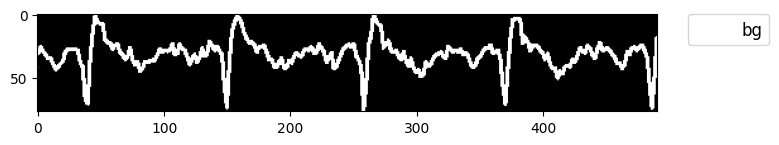

In [9]:

# Let's take a look at the segmentation map we got
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
img = Image.open('/scratch/hshang/moody/training_data/cropped_masks/9.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(1)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [13]:
# split train/val set randomly
split_dir = 'splits'
mmengine.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmengine.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

After downloading the data, we need to implement `load_annotations` function in the new dataset class `StanfordBackgroundDataset`.

In [32]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset


@DATASETS.register_module()
class ECGDataset(BaseSegDataset):
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', **kwargs)
    

KeyError: 'ECGDataset is already registered in dataset at __main__'

### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [ ]:
# Download config and checkpoint files
!mim download mmsegmentation --config unet-s5-d16_deeplabv3_4xb4-ce-1.0-dice-3.0-40k_drive-64x64 --dest .

In [23]:
from mmengine import Config
cfg = Config.fromfile('/scratch/hshang/moody/mmsegmentation_MINS/demo/unet-s5-d16_deeplabv3_4xb4-ce-1.0-dice-3.0-40k_drive-64x64.py')
print(f'Config:\n{cfg.pretty_text}')

Config:
crop_size = (
    64,
    64,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        64,
        64,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = 'data/DRIVE'
dataset_type = 'DRIVEDataset'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=4000, type='CheckpointHook'),
    logger=dict(interval=50, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
img_ratios = [
    0.5,
    0.75,
    1.0,
    1.25,
    1.5,
    1.75,
]
img_scale =

Since the given config is used to train PSPNet on the cityscapes dataset, we need to modify it accordingly for our new dataset.  

In [20]:
# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.crop_size = (256, 256)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2



# Modify dataset type and path
cfg.dataset_type = 'ECGDataset'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 8

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomResize', scale=(320, 240), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(320, 240), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]


cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'

cfg.test_dataloader = cfg.val_dataloader


# Load the pretrained weights
cfg.load_from = 'deeplabv3_unet_s5-d16_ce-1.0-dice-3.0_64x64_40k_drive_20211210_201825-6bf0efd7.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/ECG'

cfg.train_cfg.max_iters = 400
cfg.train_cfg.val_interval = 200
cfg.default_hooks.logger.interval = 10
cfg.default_hooks.checkpoint.interval = 200

# Set seed to facilitate reproducing the result
cfg['randomness'] = dict(seed=0)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')
config=f'/scratch/hshang/moody/mmsegmentation_MINS/demo/deeplabv3_unet_s5-d16_ce-1.0-dice-3.0_64x64_40k_drive-ecg.py'
with open(config, 'w') as f:
    f.write(cfg.pretty_text)

Config:
crop_size = (
    256,
    256,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        64,
        64,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = '/scratch/hshang/moody/training_data'
dataset_type = 'ECGDataset'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=200, type='CheckpointHook'),
    logger=dict(interval=10, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
img_ratios = [
    0.5,
    0.75,
    1.0,
    1.25,
    1.5,

In [24]:
from mmengine import Config
cfg = Config.fromfile('/scratch/hshang/moody/mmsegmentation_MINS/demo/deeplabv3_unet_s5-d16_ce-1.0-dice-3.0_64x64_40k_drive-ecg.py')

### Train and Evaluation

In [27]:
from mmengine import Config
cfg = Config.fromfile('/scratch/hshang/moody/mmsegmentation_MINS/demo/deeplabv3_unet_s5-d16_ce-1.0-dice-3.0_64x64_40k_drive-ecg.py')
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

08/18 01:55:17 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.19 (default, Mar 20 2024, 19:58:24) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 0
    GPU 0,1,2,3: NVIDIA TITAN X (Pascal)
    CUDA_HOME: /usr
    NVCC: Cuda compilation tools, release 11.2, V11.2.152
    GCC: gcc (Debian 10.2.1-6) 10.2.1 20210110
    PyTorch: 1.12.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compu

In [28]:


runner.train()

ValueError: palette does not match classes as metainfo is {'classes': 'signal', 'palette': [[255, 255, 255]], 'label_map': None, 'reduce_zero_label': False}.

In [9]:
import torch
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

torch.cuda.empty_cache()



Inference with trained model

/scratch/hshang/moody/mmsegmentation_MINS/mmseg/models/decode_heads/decode_head.py:120: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert `seg_logits` into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/scratch/hshang/moody/mmsegmentation_MINS/mmseg/models/losses/cross_entropy_loss.py:237: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: /scratch/hshang/moody/mmsegmentation_MINS/demo/work_dirs/ECG/iter_400.pth


/scratch_net/narigpu01/hshang/conda_envs/openmmlab/lib/python3.8/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


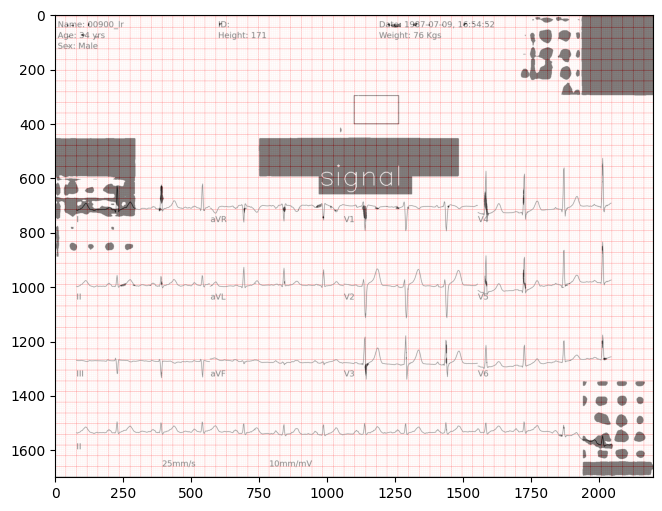

In [3]:
from mmseg.apis import init_model, inference_model, show_result_pyplot
import matplotlib.pyplot as plt

# Init the model from the config and the checkpoint
checkpoint_path = '/scratch/hshang/moody/mmsegmentation_MINS/demo/work_dirs/ECG/iter_400.pth'
model = init_model(cfg, checkpoint_path, 'cuda:1')

img = mmcv.imread('ECGData copy/images/00900_lr-0.png')
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result)
plt.imshow(mmcv.bgr2rgb(vis_result))
